# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\Acer\AppData\Local\Temp\ipykernel_16456\3881018111.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

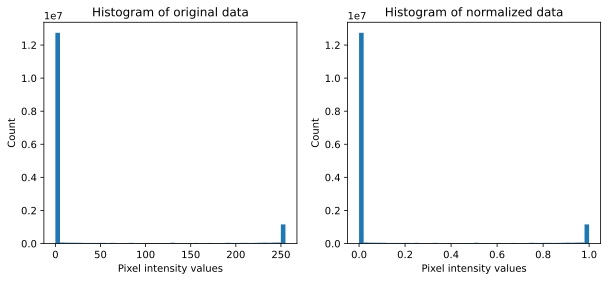

In [3]:
# normalize the data to a range of [0 1]
# putting [0 255] value range fed into a model is not a good idea
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

# most of the pixel values drawn on canvas are white (255)

plt.show()

# Create train/test groups using DataLoader

In [4]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm           ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display            module           <module 'IPython.display'<...>es\\IPython\\display.py'>
fig                Figure           Figure(1000x400)
labels             ndarray          20000: 20000 elems, type `float64`, 

# Create the DL model

In [6]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  # if we use "cross entropy loss" which already has "log(softmax)" at the output layer
  # then we don't have to specify "log_softmax" in the layer architecture anymore
  lossfun = nn.NLLLoss() 
  # optimizer
  # we use a regular optimizer 'SGD' (low performance) instead of 'Adam', 'RMsprop', ...
  # to see the effect of using log-softmax instead of softmax   
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [13]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader)) # getting the first batch of train_loader
yHat = net(X)

# values are P-probability [0 -> 1]
print('P = ', torch.exp(yHat)[:5,:])

print(' ')

# values are log_e (P)
print('log_e (P) ', yHat[:5,:])

# now let's compute the loss just to know that
# everything is working
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss) 

P =  tensor([[0.0881, 0.1070, 0.1163, 0.0971, 0.1063, 0.0922, 0.1040, 0.0860, 0.1035,
         0.0995],
        [0.0878, 0.1070, 0.1152, 0.0988, 0.1052, 0.0918, 0.1049, 0.0866, 0.1034,
         0.0993],
        [0.0880, 0.1067, 0.1150, 0.0995, 0.1054, 0.0917, 0.1062, 0.0865, 0.1023,
         0.0987],
        [0.0877, 0.1073, 0.1158, 0.0978, 0.1065, 0.0917, 0.1052, 0.0858, 0.1032,
         0.0990],
        [0.0879, 0.1075, 0.1154, 0.0991, 0.1064, 0.0922, 0.1042, 0.0852, 0.1036,
         0.0986]], grad_fn=<SliceBackward0>)
 
log_e (P)  tensor([[-2.4291, -2.2348, -2.1517, -2.3321, -2.2412, -2.3838, -2.2634, -2.4533,
         -2.2683, -2.3078],
        [-2.4325, -2.2352, -2.1610, -2.3143, -2.2517, -2.3885, -2.2552, -2.4461,
         -2.2691, -2.3096],
        [-2.4306, -2.2381, -2.1632, -2.3074, -2.2497, -2.3890, -2.2422, -2.4472,
         -2.2798, -2.3162],
        [-2.4341, -2.2322, -2.1557, -2.3245, -2.2399, -2.3888, -2.2517, -2.4562,
         -2.2711, -2.3130],
        [-2.4320, -2.230

# Create a function that trains the model

In [14]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [15]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


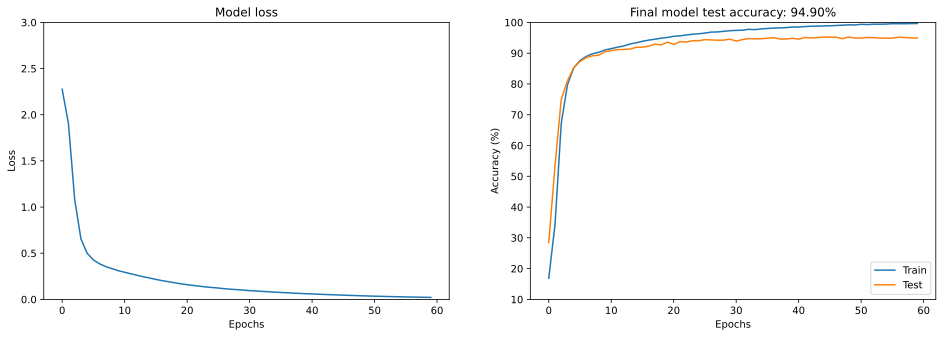

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [19]:
# run the model through for the test data
X,y = next(iter(test_loader))

# showing result of log(softmax) vs softmax to show how it might impact the model
predictions = net(X).detach()

print('log(softmax): ', predictions[0,:])
print(' ')
print('softmax: ', torch.exp(predictions)[0,:])

# we see that if we were to use 'softmax' value to train the model by default
# the model has to work with very small numbers that at machine-precise level
# which is hard for numerical performance

log(softmax):  tensor([ -3.8597, -15.8939,  -4.7356,  -0.0368, -23.5297,  -7.3672, -18.0621,
        -12.9845,  -5.2408,  -8.0290])
 
softmax:  tensor([2.1075e-02, 1.2514e-07, 8.7774e-03, 9.6389e-01, 6.0422e-11, 6.3166e-04,
        1.4313e-08, 2.2955e-06, 5.2960e-03, 3.2586e-04])


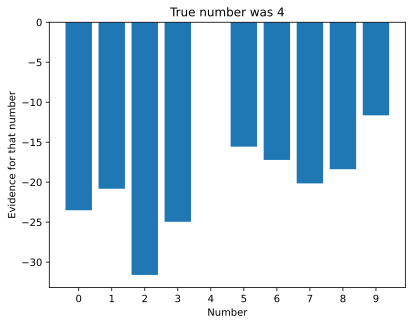

In [20]:
# select one sample (index)
sample2show = 120

# showing prediction result for that one sample
plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')    
plt.ylabel('model output for that number')
plt.title('True number was %s' %y[sample2show].item()) # true label
plt.show()

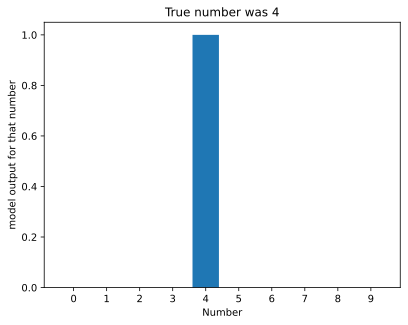

In [21]:
# select one sample (index)
sample2show = 120

# showing prediction result for that one sample
plt.bar(range(10),torch.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')    
plt.ylabel('model output for that number')
plt.title('True number was %s' %y[sample2show].item()) # true label
plt.show()

[  12   30   44  125  126  144  156  184  210  215  247  251  272  279
  308  317  329  358  415  429  432  434  435  443  449  463  480  490
  508  529  540  546  585  596  606  629  686  716  811  824  858  876
  893  910  926  941  947  949  970  972  976 1052 1055 1095 1117 1126
 1127 1143 1150 1228 1268 1274 1307 1308 1325 1328 1333 1387 1408 1415
 1461 1487 1489 1503 1506 1518 1554 1570 1582 1594 1616 1634 1642 1671
 1679 1685 1703 1709 1718 1732 1767 1787 1812 1843 1854 1861 1876 1878
 1916 1930 1965 1987]


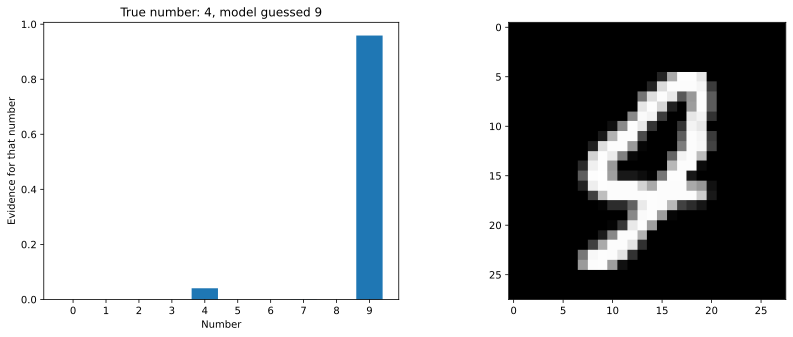

In [25]:
# ofcourse the model got 5% of the number wrong
# we want to have more insight on those errors
# we want to find the case where the model makes mistake and look at those images 
# and try to get a sense of what went wrong 

# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors) # all the indices that wrongly guessed by the model

# pick one
sample2show = 11

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# after looking at the result, we kind of understand why the model confused
# we might go back to the dataset and remove some of them 

# Additional explorations

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 